# Milestone 2 : Project proposal and initial analyses 🍻

<hr style="clear:both">
This notebook was made for the ADA course at EPFL. 

Group : BeerADAventure46

**Authors:** \
[Agatha Hunter](https://people.epfl.ch/agatha.hunter)\
[Anne-Valérie Preto](https://people.epfl.ch/anne-valerie.preto)\
[Tristan Carruzzo](https://people.epfl.ch/tristan.carruzzo)\
[Thamin Maurer](https://people.epfl.ch/thamin.maurer)\
[Victor Dubien](https://people.epfl.ch/victor.dubien)


**Supervisor:**\
[Beatriz Borges](https://people.epfl.ch/beatriz.borges)
<hr style="clear:both">



<blockquote>

## Project proposal  📌

**Influence of the serving style on the tasting profile**:

Goal of the project: Use the textual reviews to find for each beer how it was served (either bottle, can or draft) and find how it influences the tasting profile.

Different serving styles may be adopted in different regions or for different types of beer.  The influence of the serving style could influence not only the appearance, but also the aroma, the palate or the taste.
</blockquote>

### TODO LIST FOR THE GROUP:

<input type="checkbox" checked > New architecture of file

<input type="checkbox"> Create functions to import and convert initial files

<input type="checkbox"> More comments on the dataset -> distribution, viz

<input type="checkbox"> For any filtering: how, why ?

<input type="checkbox"> Choose a NLP method -> comment as much as possible, some trials 

<input type="checkbox"> E-mail the proposition to Beatriz

## Datasets 📂
### Import dataset and libraries 📥

In [1]:
import io
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from langdetect import detect
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

from textstat import flesch_reading_ease, flesch_kincaid_grade, gunning_fog, smog_index, automated_readability_index, coleman_liau_index, linsear_write_formula, dale_chall_readability_score, text_standard
from utils import *
pd.set_option('display.max_columns', None)

In [2]:
dataset_path = './data/BeerAdvocate/'

In [3]:
#ratings_2 = convert_txt_to_csv(input_file='ratings.txt', export=True, file_name='trial_ratings')
#can take a while to run

In [4]:
# Firt time imports : 
# Convert txt to csv (function in the utils.py file)

#ratings = convert_txt_to_csv(input_file='ratings.txt', export=True, file_name='ratings')
#reviews = convert_txt_to_csv(input_file='reviews.txt', export=True, file_name='reviews')

In [5]:
# Files already converted, so we can load them directly

#ratings = pd.read_csv(dataset_path + 'ratings.csv')
reviews = pd.read_csv(dataset_path + 'reviews.csv')
beers = pd.read_csv(dataset_path + 'beers.csv')
breweries = pd.read_csv(dataset_path + 'breweries.csv')
users = pd.read_csv(dataset_path + 'users.csv')

### Initial datasets analysis 🔎

#### Beers dataset 🍺

In [6]:
display(beers.sample(3))
print('Shape of beers : ', beers.shape)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
83058,172867,Double Oh 7,30584,Thorn Street Brewery,English Pale Ale,2,0,3.57,NaN,NaN,5.2,3.5650,-0.856897,0,NaN
154944,86905,Black Lagoon,28383,Tired Hands Brewing Company,Saison / Farmhouse Ale,20,3,3.70,84.0,NaN,8.0,3.6215,NaN,0,NaN
125320,105507,Saranac Tramonay Reserve,99,Matt Brewing Company / Saranac Brewery,American IPA,3,0,3.50,NaN,NaN,6.5,3.5000,NaN,0,NaN


Shape of beers :  (280823, 15)


In [7]:
# print the number of beers id and beer name
print('Number of different beers id:', len(beers.beer_id.unique()))
print('Number of different beers name:', len(beers.beer_name.unique()))

Number of different beers id: 280823
Number of different beers name: 236209


<blockquote>

**Initial comments about the dataset**

-Some beers have the same name! In order to avoid confusion, we will drop the column beer_name (and brewery_name) from the dataset.

-As we will not use the RateBeer dataset, we can also drop the column nbr_matched_valid_ratings and avg_matched_valid_ratings.  

-The column bros_score only reflect the ratings from the two creators of the website, so we can also drop it.  

-ba_score reprensents the percentage (rounded to the tenth for depth) of raters who gave the beer a 3.75 or higher as long as the beers as at least 10 ratings.

</blockquote>

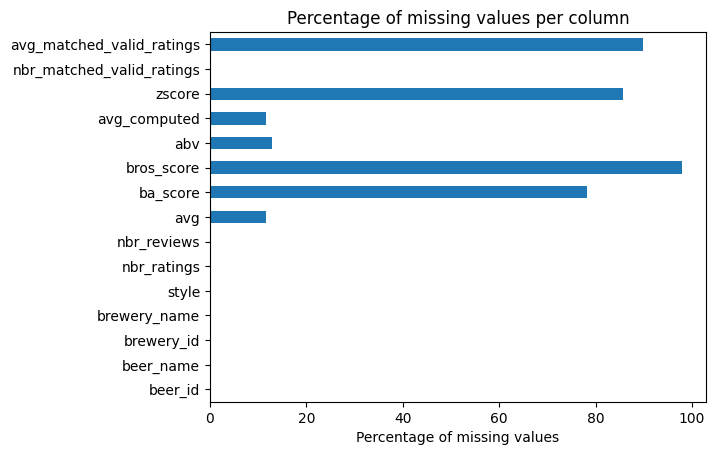

In [8]:
# show the percentage of missing values per columm
plt.figure()
(beers.isna().sum() / len(beers) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

<blockquote>

**More comments about the dataset**

We see that more than 80% of the beers do not have a z-score value. We can drop this column alongside avg_computed and compute them manually later if needed.

80% of the beers have no ba_score value, so we can also drop it and compute it later if needed.

</blockquote>

In [9]:
beers_filtered = beers.drop(columns=['beer_name', 
                            'brewery_name',
                            'bros_score',
                            'ba_score',
                            'nbr_matched_valid_ratings',
                            'avg_matched_valid_ratings',
                            'zscore',
                            'avg_computed']).copy(deep=True)

beers_filtered.rename(columns={'nbr_ratings': 'beer_nbr_ratings',
                               'nbr_reviews': 'beer_nbr_reviews'}, inplace=True)

In [10]:
beers_filtered.sample(3)

,beer_id,brewery_id,style,beer_nbr_ratings,beer_nbr_reviews,avg,abv
131815,87570,29972,Belgian Strong Dark Ale,10,5,3.65,9.5
205677,230946,31805,American Pale Ale (APA),1,0,5.00,6.1
175819,42820,3196,English India Pale Ale (IPA),21,9,3.23,NaN


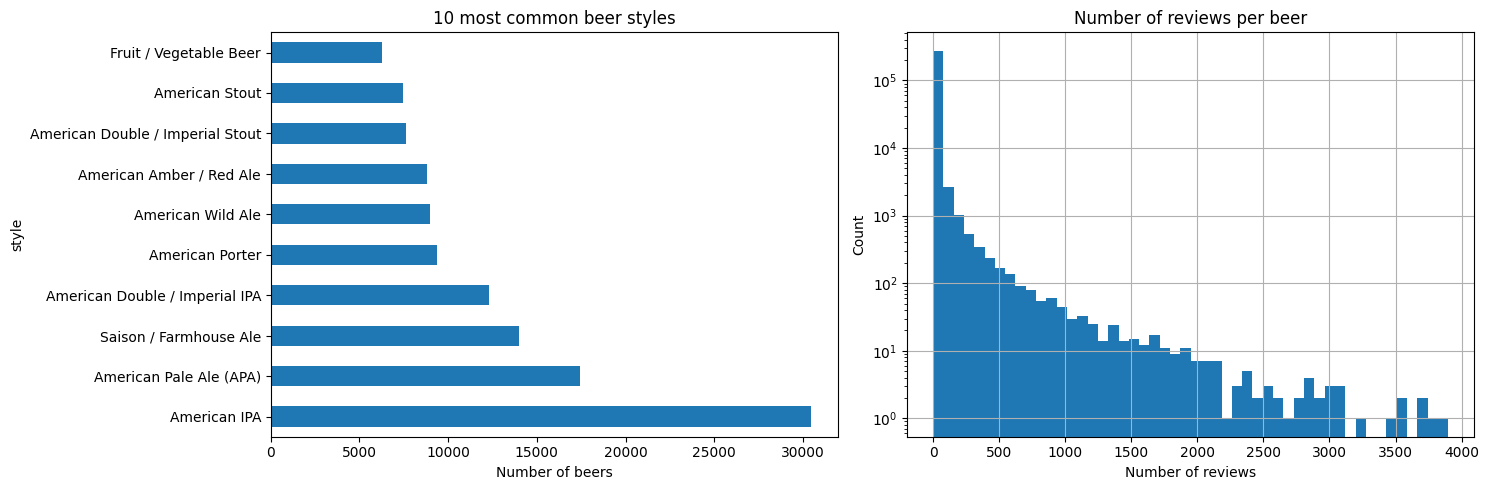

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
beers_filtered['style'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common beer styles')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
beers_filtered['beer_nbr_reviews'].hist(bins=50,log=True)
plt.title('Number of reviews per beer')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.tight_layout()
plt.show()

In [12]:
# Some beers have no reviews and no ratings, resulting in NaN avg value, we remove them
beers_filtered = beers_filtered[beers_filtered['avg'].notna()].copy(deep=True)

# We also remove the few beers that have 0 reviews and 0 ratings but a non NaN avg value (not sure why there are such beers)
beers_filtered = beers_filtered[(beers_filtered['beer_nbr_reviews'] != 0) & (beers_filtered['beer_nbr_ratings'] != 0)].copy(deep=True)

In [13]:
beers_filtered.describe()

,beer_id,brewery_id,beer_nbr_ratings,beer_nbr_reviews,avg,abv
count,166649.000000,166649.000000,166649.000000,166649.000000,166649.000000,144879.000000
mean,118304.063271,17174.929871,49.216653,15.539163,3.709953,6.566462
std,82294.748008,14573.636775,298.336124,88.846266,0.489242,2.138165
min,3.000000,1.000000,1.000000,1.000000,1.000000,0.010000
25%,50831.000000,1853.000000,2.000000,1.000000,3.500000,5.000000
50%,95991.000000,16111.000000,5.000000,2.000000,3.780000,6.000000
75%,184603.000000,30176.000000,17.000000,5.000000,4.020000,7.600000
max,293285.000000,49815.000000,16509.000000,3899.000000,5.000000,67.500000


<blockquote>

We are left with a clean dataset containing 166'649 beers. Some beers do not have a alcohol percentage value.

</blockquote>

#### Breweries dataset 🏭

In [14]:
display(breweries.sample(3))
print('Shape of breweries : ', breweries.shape)

,id,location,name,nbr_beers
16582,12984,"United States, Washington",Rocky Coulee Brewing Co.,2
13864,29568,"United States, Texas",Pedernales Brewing Company,17
15257,10821,Austria,Brigitta-Bräu,3


Shape of breweries :  (16758, 4)


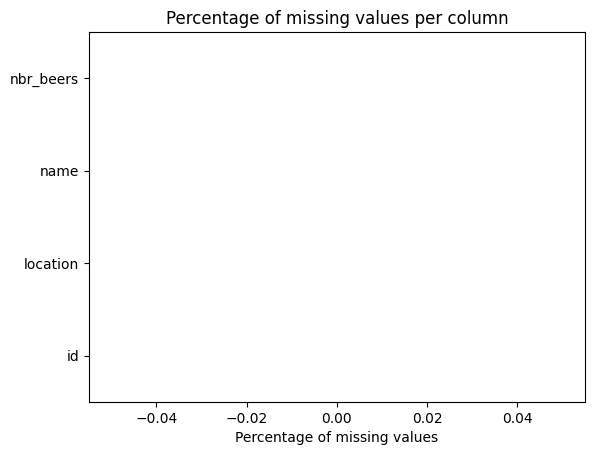

In [15]:
# show the percentage of missing values per columm
plt.figure()
(breweries.isna().sum() / len(breweries) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

<blockquote>

This dataset has no missing values, we will simply rename the columns and drop the brewery name.

</blockquote>

In [16]:
breweries_filtered = breweries.drop(columns=['name']).copy(deep=True)
breweries_filtered.rename(columns={'id':'brewery_id',
                                   'location':'brewery_location',
                                   'nbr_beers':'brewery_nbr_beers'}, inplace=True)

In [17]:
breweries_filtered.sample(3)

,brewery_id,brewery_location,brewery_nbr_beers
15037,19142,France,0
6890,2055,Czech Republic,27
16436,3075,"United States, Maryland",1


In [18]:
# Some breweries have weird location values, should find a way to clean them or simply remove them
for loc in breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_location'].unique()[0:5]:
    print(loc) # print the first 5 strange values

United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bluecorncafe.com" target="_blank">bluecorncafe.com
United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://leinie.com" target="_blank">leinie.com
United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://gordonbiersch.com" target="_blank">gordonbiersch.com
United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bigbuck.com" target="_blank">bigbuck.com
United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bjsrestaurants.com" target="_blank">bjsrestaurants.com


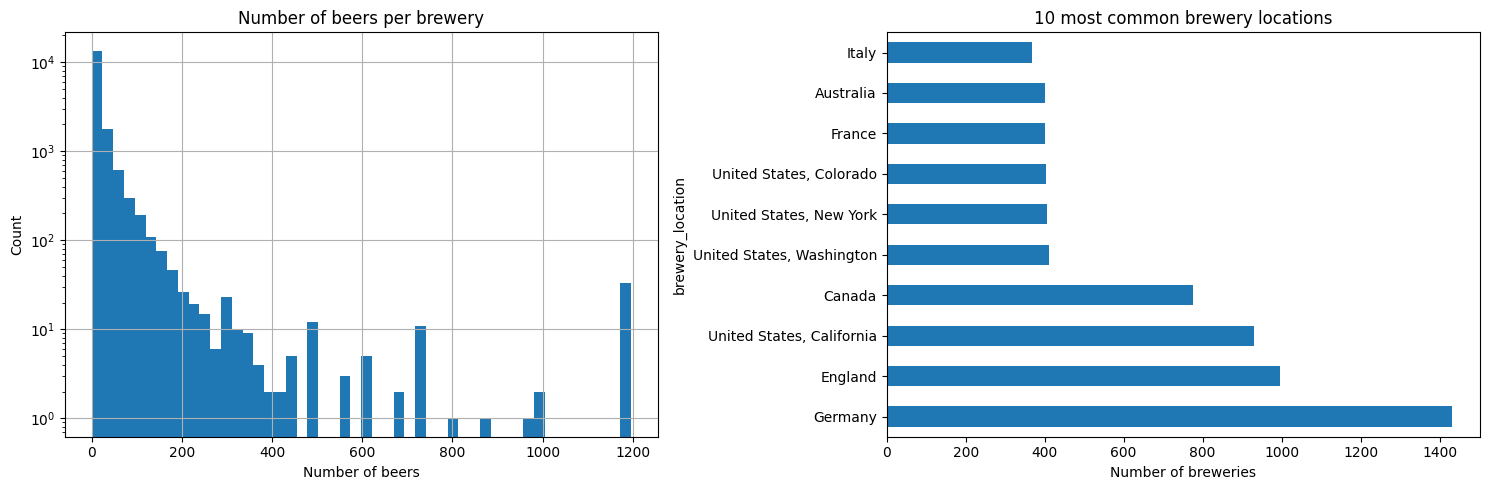

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
breweries_filtered['brewery_nbr_beers'].hist(bins=50, log=True)
plt.title('Number of beers per brewery')
plt.ylabel('Count')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
breweries_filtered['brewery_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common brewery locations')
plt.xlabel('Number of breweries')
plt.tight_layout()
plt.show()

#### Users dataset 👤

In [20]:
display(users.sample(3))
print('Shape of users : ', users.shape)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
34159,45,0,gofacethecraftcooler.861561,gofacethecraftcooler,1.410430e+09,"United States, Kansas"
27440,4,0,gr8one99.886873,Gr8one99,1.414926e+09,"United States, California"
11002,301,0,dbot.109945,Dbot,1.165057e+09,"United States, Delaware"


Shape of users :  (153704, 6)


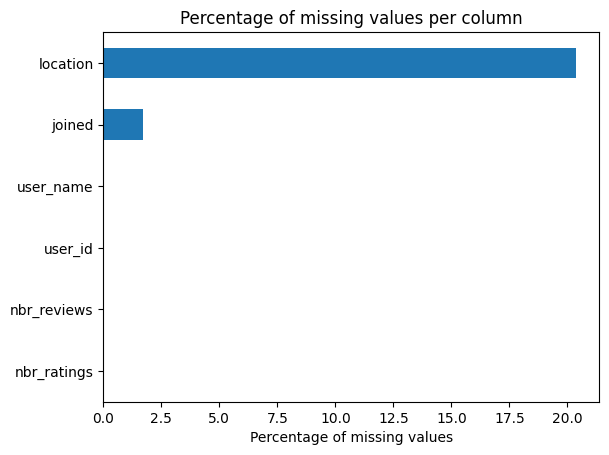

In [21]:
plt.figure()
(users.isna().sum() / len(users) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

<blockquote>

We are only missing information about when the user joined the website and locations. (and 1 username, which we drop anyway)

</blockquote>

In [22]:
users_filtered = users.drop(columns=['user_name']).copy(deep=True)

users_filtered.rename(columns={'nbr_ratings':'user_nbr_ratings',
                               'nbr_reviews':'user_nbr_reviews',
                               'joined':'user_joined',
                               'location':'user_location'}, inplace=True)

users_filtered.sample(3)

,user_nbr_ratings,user_nbr_reviews,user_id,user_joined,user_location
136076,1,0,gwjames.506232,1.285150e+09,"United States, Kansas"
83941,2,1,aberod1986.953491,1.425467e+09,"United States, South Carolina"
150583,2,2,jkpm.533910,1.291374e+09,Ireland


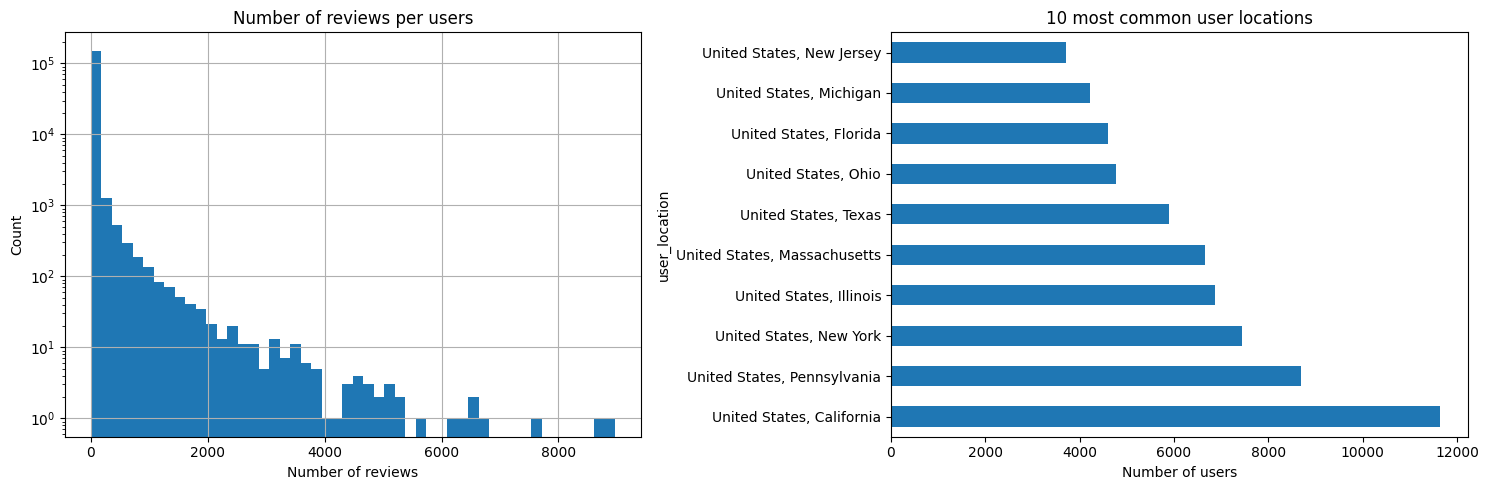

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
users_filtered['user_nbr_reviews'].hist(bins=50, log=True)
plt.title('Number of reviews per users')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.subplot(1, 2, 2)
users_filtered['user_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common user locations')
plt.xlabel('Number of users')
plt.tight_layout()
plt.show()

<blockquote>

We observe that many users have no reviews at all, they will be removed from the dataset when merging. Also, the 10 most common user location are all in the US.

</blockquote>

#### Reviews dataset 📝

In [24]:
display(reviews.sample(3))
print('Shape of reviews : ', reviews.shape)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
858299,Stone 7th Anniversary Ale,11860,Stone Brewing,147,American Pale Ale (APA),7.7,1105527600,carln26,carln26.5165,4.0,4.5,4.0,4.50,4.0,4.32,"Dull copper to amber color, slightly hazy with..."
2412504,Houblon Chouffe Dobbelen IPA Tripel,27804,Brasserie d'Achouffe,321,Belgian IPA,9.0,1390042800,ONovoMexicano,onovomexicano.680970,3.0,4.0,3.5,3.75,3.5,3.69,I will confess that I picked up a 12 ounce bot...
671848,Sierra Nevada Celebration Ale,1904,Sierra Nevada Brewing Co.,140,American IPA,6.8,1232276400,dudecandle,dudecandle.181976,4.0,5.0,3.5,4.00,3.5,4.09,"As soon as I opened the bottle, I was smacked ..."


Shape of reviews :  (2589586, 16)


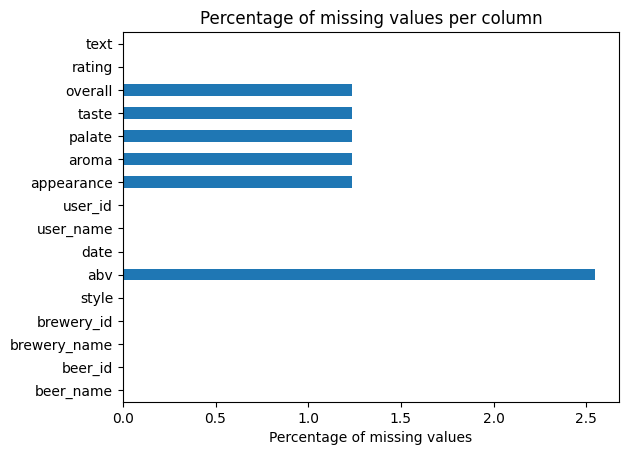

In [25]:
plt.figure()
(reviews.isna().sum() / len(reviews) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

In [26]:
# making sure that all the NaN are in the same rows

# print the number of rows that contains a NaN value for each column ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of rows with NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews[reviews[col].isna()]))
    
missing_values = reviews[['overall', 'taste', 'palate', 'aroma', 'appearance']].isna()
missing_values['all_missing'] = missing_values.all(axis=1)
print(missing_values['all_missing'].value_counts())

Number of rows with NaN values for each column :
overall : 32009
taste : 32009
palate : 32009
aroma : 32009
appearance : 32009
all_missing
False    2557577
True       32009
Name: count, dtype: int64


<blockquote>

All the missing values are in the same rows, and they represent less than 1.5% of the dataset. We can then drop them.

</blockquote>

In [27]:
# remove the columns that are not useful for our analysis

reviews_filtered = reviews.drop(columns=['user_name', 'beer_name', 'brewery_name']).copy(deep=True)

#remove rows in reviews_filtered that have all_missing True in missing_values
reviews_filtered = reviews_filtered[~missing_values['all_missing']].copy(deep=True)

display(reviews_filtered.sample(3))
print('Shape of reviews_filtered : ', reviews_filtered.shape)

,beer_id,brewery_id,style,abv,date,user_id,appearance,aroma,palate,taste,overall,rating,text
1689881,2093,64,American Double / Imperial IPA,9.0,1209204000,brewlore.99149,4.5,4.0,4.0,4.0,4.0,4.03,Poured from a 12oz bottleLooks quite similar t...
281188,2140,360,Low Alcohol Beer,0.5,1242468000,suds.364,3.5,2.5,2.5,3.0,3.5,2.96,"For an NA beer, this one isn't bad at all. I p..."
573318,52077,220,American Double / Imperial IPA,8.5,1260615600,randawakes.156046,4.5,4.0,4.0,4.5,4.0,4.23,On tap at the Rogue Ales Public House in San F...


Shape of reviews_filtered :  (2557577, 13)


In [28]:
# count the number of NaN in columns ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews_filtered[reviews_filtered[col].isna()]))


Number of NaN values for each column :
overall : 0
taste : 0
palate : 0
aroma : 0
appearance : 0


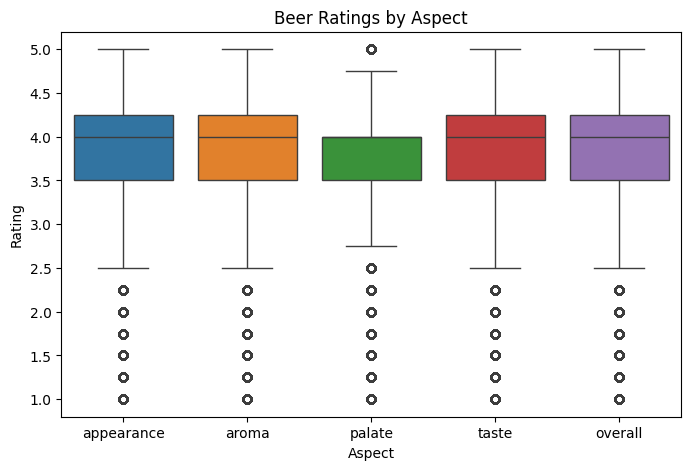

In [29]:
# show boxplot for each rating column, appearance, aroma, palate, taste and overall

plt.figure(figsize=(8, 5))
sns.boxplot(data=reviews_filtered[['appearance', 'aroma', 'palate', 'taste', 'overall']])
plt.title('Beer Ratings by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.show()

### Merge datasets 🔗

In [30]:
# Merge reviews with users and beers and breweries
df_merged = reviews_filtered.merge(beers_filtered, how='left', on=['beer_id', 'brewery_id', 'style', 'abv'])
df_merged = df_merged.merge(users_filtered, how='left', on='user_id')
df_merged = df_merged.merge(breweries_filtered, how='left', on='brewery_id')

display(df_merged.sample(1))
print('Shape of df_merged : ', df_merged.shape)

,beer_id,brewery_id,style,abv,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
2524927,16436,354,American Stout,4.1,1225796400,sackerz9.15564,4.5,3.0,2.0,3.5,3.0,3.19,Poured from a 12oz bottle into a pint glass. P...,43,42,3.56,1162,1072,NaN,NaN,"United States, North Carolina",28


Shape of df_merged :  (2557577, 22)


### Filter datasets ✂️

<div class="alert alert-block alert-danger">
<b>Danger:</b> Comment EVERY filtering
</div>

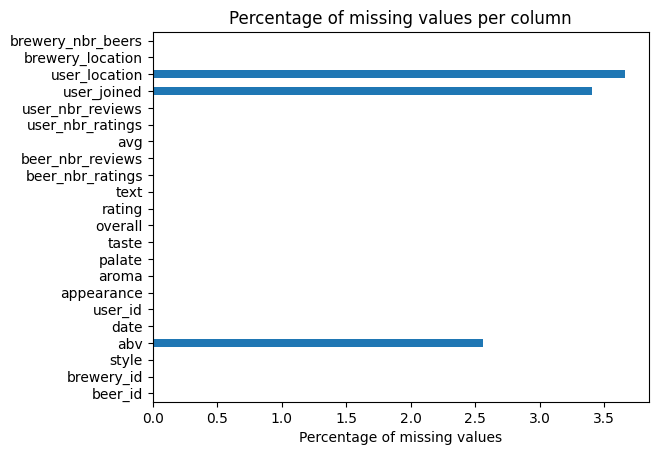

In [31]:
# show the percentage of missing values per columm
plt.figure()
(df_merged.isna().sum() / len(df_merged) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

In [32]:
# Save to csv
df_merged.to_csv(dataset_path + 'BeerAdvocateMerged.csv', index=False)

In [ ]:
df = pd.read_csv(dataset_path + 'BeerAdvocateMerged.csv')

In [ ]:
display(df.sample(3))
print('Shape of df : ', df.shape)

## Data enrichment 🍺
### Serving type 🍾🥤🚰

>Since our goal is to look at the influence of the serving style, we need to know how each beer was served. 
For now, we use a naive approach. We only look at whether a word specific to as service style has been used. 


In [ ]:
# Create 3 different columns according to the text review, "bottle", "can", "draft"

bottle = ['bottle', 'bottled', 'bottles']
can = [' can ', 'canned', ' cans ']
draft = ['draft', 'draught', 'tap', 'taps']
# Create different columns if review text contains the word
df['bottle'] = df['text'].apply(lambda x: any(ele in x.lower() for ele in bottle))
df['can'] = df['text'].apply(lambda x: any(ele in x.lower() for ele in can))
df['draft'] = df['text'].apply(lambda x: any(ele in x.lower() for ele in draft))

In [ ]:
# remove every row where columns bottle, can and draft are all False
df = df[df[['bottle', 'can', 'draft']].any(axis=1)]
# display(df.sample(3))
# print('We have {} valid reviews'.format(df.shape[0]))

# remove every row with more than 1 true
df = df[df[['bottle', 'can', 'draft']].sum(axis=1) == 1]
# display(df.sample(3))
# print('We have {} valid reviews'.format(df.shape[0]))

#create a new column with the serving type
df['serving_type'] = df[['bottle', 'can', 'draft']].idxmax(axis=1)

# drop the columns bottle, can and draft
df.drop(['bottle', 'can', 'draft'], axis=1, inplace=True)

display(df.sample(3))

# print the number of reviews for each serving type
df['serving_type'].value_counts(normalize=False)

## Data filtering 🧹
Number of valid reviews per beer and users & average rating per beer

### Filtering on amount of reviews

In [ ]:
# compute the number of valid reviews per user
df['user_nbr_reviews_computed'] = df.groupby('user_id')['user_id'].transform('count')

# compute the number of valid reviews per beer
df['beer_nbr_reviews_computed'] = df.groupby('beer_id')['beer_id'].transform('count')

# compute the avg rating per beer
df['beer_avg_computed'] = df.groupby('beer_id')['rating'].transform('mean')

df.sample(3)

In [ ]:
plt.figure(figsize=(15, 5))

# group the reviews by beer_id and show a histogram of the number of reviews computed
plt.subplot(1, 2, 1)
df.groupby('beer_id')['beer_nbr_reviews_computed'].mean().hist(bins=100, log=True)
plt.xlabel('Number of reviews per beer')
plt.ylabel('Count')

# group the reviews by user_id and show a histogram of the number of reviews computed
plt.subplot(1, 2, 2)
df.groupby('user_id')['user_nbr_reviews_computed'].mean().hist(bins=100, log=True)
plt.xlabel('Number of reviews per user')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
#Filtering to remove users and beers with less reviews

min_nbr_reviews_per_user = 0
min_nbr_reviews_per_beer = 20

len0 = df.shape[0]

# remove every row where the number of reviews per user is less than min_nbr_reviews_per_user
df_filter = df[df['user_nbr_reviews_computed'] >= min_nbr_reviews_per_user].copy(deep=True)

# remove every row where the number of reviews per beer is less than min_nbr_reviews_per_beer
df_filter_full = df_filter[df_filter['beer_nbr_reviews_computed'] >= min_nbr_reviews_per_beer].copy(deep=True)

print('We removed {} rows, leaving us with {} %% of the original dataset'.format(len0 - df_filter_full.shape[0], round(df_filter_full.shape[0] / len0 * 100, 2)))
print('We have {} valid reviews'.format(df_filter_full.shape[0]))

# print the number of reviews for each serving type
df_filter_full['serving_type'].value_counts(normalize=False)

### Filter on readability score of the reviews 📝

In [ ]:
df_sample = df_filter_full.sample(n=1000, random_state=46)

In [ ]:
df_sample['readability_score'] = df_sample['text'].apply(lambda x: flesch_reading_ease(x) if isinstance(x, str) else None)
df_sample['readability_score'].hist(bins=100, figsize=(15, 5), log=True)

In [ ]:
# printing some reviews based on readability score

df_sample[df_sample['readability_score'] < 20]['text'].count()

# for row in df_sample[df_sample['readability_score'] > 96]['text']:
#     print(row)
#     print('----------------------')

In [ ]:
# remove reviews with bad readability score



### Extracting the serving mode with NLP

In [ ]:
import nltk
import spacy

In [ ]:
df_test_nlp = df_sample.copy(deep=True)
nlp = spacy.load("en_core_web_sm")

In [ ]:
def extract_serving_style(text):
    # Process the text using spaCy
    doc = nlp(text)
    
    # Initialize the serving style variable
    serving_style = None
    
    # Analyze the dependency tree and part-of-speech tags
    # Find the serving styles
    for token in doc:
        if "can" == token.lemma and token.dep_ == "nsubj":
            serving_style = "can"
            break
        elif "bottle" == token.lemma and token.dep_ == "nsubj" and "VB" in token.head.pos_:
            serving_style = "bottle"
            break
        elif "tap" == token.lemma and token.dep_ == "nsubj" and "VB" in token.head.pos_:
            serving_style = "tap"
            break
    
    return serving_style

In [ ]:
ex_review = str("Can. I would love to try it on tap")

In [ ]:
doc = nlp(ex_review)
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.dep_)

In [ ]:
print(extract_serving_style(ex_review))

In [ ]:
df_test_nlp['text'].sample(1)

In [ ]:
%%time
df_test_nlp['serving_style'] = df_test_nlp['text'].apply(extract_serving_style)

In [ ]:
# Look if all serving_style values are still None (True or False)
df_test_nlp['serving_style'].isna().all()

### Countries grouping 🌍

In [ ]:
countries = pd.read_csv('data/countries.csv', usecols=['name', 'region', 'sub-region'])
countries.sample(1)

### Visualization 📊

In [ ]:
df = df_filter_full.copy(deep=True)

In [ ]:
# print some reviews for each serving type
print('Reviews with bottle:\n')
for text in df[df['serving_type'] == 'bottle']['text'].sample(1):
    print(text)
    print('----------------------')
print('Reviews with can:\n')
for text in df[df['serving_type'] == 'can']['text'].sample(1):
    print(text)
    print('----------------------')
print('Reviews with draft:\n')
for text in df[df['serving_type'] == 'draft']['text'].sample(1):
    print(text)
    print('----------------------')

In [ ]:
# print the average value of the rating for each serving type
comp_str = 'rating'
print('Average ' + comp_str + ' for bottle: ', round(df[df['serving_type'] == 'bottle'][comp_str].mean(), 3))
print('Average ' + comp_str + ' for can: ', round(df[df['serving_type'] == 'can'][comp_str].mean(), 3))
print('Average ' + comp_str + ' for draft: ', round(df[df['serving_type'] == 'draft'][comp_str].mean(), 3))

In [ ]:
# show boxplot and histograms of ratings for bottle, can and draft
plt.figure(figsize=(10, 6))
plt.subplot(121)
sns.boxplot(data=df, hue='serving_type', y='rating')
plt.subplot(122)
sns.histplot(data=df, hue='serving_type', x='rating', kde=True, bins=20)
plt.tight_layout()
plt.show()

# Statistical Analysis 📈

### Measure the impact of each aspect on rating 📏

In [ ]:
# fit a linear regression line to the data for all 5 aspects
reg1 = LinearRegression().fit(df[['appearance']], df['rating'])
reg2 = LinearRegression().fit(df[['aroma']], df['rating'])
reg3 = LinearRegression().fit(df[['palate']], df['rating'])
reg4 = LinearRegression().fit(df[['taste']], df['rating'])
reg5 = LinearRegression().fit(df[['overall']], df['rating'])

# create subplots for all 5 aspects
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# plot the data and regression line for each aspect
sns.scatterplot(data=df, x='appearance', y='rating', s=0.5, ax=axs[0])
axs[0].plot(df[['appearance']], reg1.predict(df[['appearance']]), color='red')
axs[0].set_title('Appearance\nSlope = ' + str(round(reg1.coef_[0], 3)) + '\nR2 = ' + str(round(reg1.score(df[['appearance']], df['rating']), 3)))

sns.scatterplot(data=df, x='aroma', y='rating', s=0.5, ax=axs[1])
axs[1].plot(df[['aroma']], reg2.predict(df[['aroma']]), color='red')
axs[1].set_title('Aroma\nSlope = ' + str(round(reg2.coef_[0], 3)) + '\nR2 = ' + str(round(reg2.score(df[['aroma']], df['rating']), 3)))

sns.scatterplot(data=df, x='palate', y='rating', s=0.5, ax=axs[2])
axs[2].plot(df[['palate']], reg3.predict(df[['palate']]), color='red')
axs[2].set_title('Palate\nSlope = ' + str(round(reg3.coef_[0], 3)) + '\nR2 = ' + str(round(reg3.score(df[['palate']], df['rating']), 3)))

sns.scatterplot(data=df, x='taste', y='rating', s=0.5, ax=axs[3])
axs[3].plot(df[['taste']], reg4.predict(df[['taste']]), color='red')
axs[3].set_title('Taste\nSlope = ' + str(round(reg4.coef_[0], 3)) + '\nR2 = ' + str(round(reg4.score(df[['taste']], df['rating']), 3)))

sns.scatterplot(data=df, x='overall', y='rating', s=0.5, ax=axs[4])
axs[4].plot(df[['overall']], reg5.predict(df[['overall']]), color='red')
axs[4].set_title('Overall\nSlope = ' + str(round(reg5.coef_[0], 3)) + '\nR2 = ' + str(round(reg5.score(df[['overall']], df['rating']), 3)))

plt.tight_layout()
plt.show()

# should still add confidence intervals

It seems like Taste as the biggest impact on the rating while appearance has the least impact.

### Hypothesis testing on the new labels

In [ ]:
def do_ttest(type1, type2, category):
    ttest = ttest_ind(df[df['serving_type'] == type1][category],df[df['serving_type'] == type2][category])
    if ttest[1] > 0.05:
        print('The p-value is high (' + str(ttest[1]) + '), so we cannot reject the null hypothesis that the two samples have the same average')
    else:
        print('The p-value is very low (' + str(ttest[1]) + '), so we can reject the null hypothesis that the two samples have the same average')

In [ ]:
# define the columns to compare
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

# create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(df[df['serving_type'] == 'bottle'][columns[i]], df[df['serving_type'] == 'can'][columns[i]])
    ttest2 = ttest_ind(df[df['serving_type'] == 'can'][columns[i]], df[df['serving_type'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(df[df['serving_type'] == 'draft'][columns[i]], df[df['serving_type'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, p_values[:,0], width, label='Bottle vs Can')
rects2 = ax.bar(x, p_values[:,1], width, label='Can vs Draft')
rects3 = ax.bar(x + width, p_values[:,2], width, label='Draft vs Bottle')
ax.set_xticks(x)
# ax.set_yscale('log')
ax.set_xticklabels(columns)
ax.set_ylabel('p-value')
ax.set_title('Comparison of Aspects between Service Types')
ax.legend()
plt.show()

All the p-values are below 0.05 (expect 1), so we can reject the null hypothesis and conclude that there is a significant difference between the groups.

In [ ]:
# t-test for aroma betwwen draft and bottle
do_ttest('draft', 'bottle', 'aroma')

In [ ]:
# show a boxplot of aroma for draft and bottle
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['serving_type'].isin(['draft', 'bottle'])], x='serving_type', y='aroma')
plt.show()